<h2>Predict The News Category Hackathon</h2>

From the beginning, since the first printed newspaper, every news that makes into a page has had a specific section allotted to it. Although pretty much everything changed in newspapers from the ink to the type of paper used, this proper categorization of news was carried over by generations and even to the digital versions of the newspaper. Newspaper articles are not limited to a few topics or subjects, it covers a wide range of interests from politics to sports to movies and so on. For long, this process of sectioning was done manually by people but now technology can do it without much effort. In this hackathon, Data Science and Machine Learning enthusiasts like you will use Natural Language Processing to predict which genre or category a piece of news will fall in to from the story.<br/>

Size of training set: 7,628 records<br/>
Size of test set: 2,748 records<br/>

<b>FEATURES</b>:<br/>

<b>STORY</b>:  A part of the main content of the article to be published as a piece of news.<br/>
<b>SECTION</b>: The genre/category the STORY falls in.<br/>

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :<br/>

Politics: 0 <br/>
Technology: 1 <br/>
Entertainment: 2 <br/>
Business: 3 <br/>

In [232]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import pickle
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummary import summary
from torch.optim import lr_scheduler
import operator
import json
#from xgboost import XGBClassifier
import re, string
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder, scale, MultiLabelBinarizer
from sklearn.datasets import load_boston
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from pandas.plotting import scatter_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from datetime import datetime
from scipy import stats
from sklearn.svm import SVC
import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from torch.autograd import Variable
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
#import cufflinks as cf

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from nltk.tokenize.treebank import TreebankWordTokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
pd.set_option('display.max_columns', 500)

#init_notebook_mode(connected=True)
#cf.go_offline()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [233]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding="utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [234]:
def create_aggregrated_plots(feature_name, target, bubble_size_adj=0.1 , aggregration='mean'):

    _tmp_material = train.groupby([target])[feature_name].mean()
    fig = go.Figure()
    color_values = list(_tmp_material.values.astype(int))
    tmp_trace = []

    fig.add_trace(go.Scatter(
        x=_tmp_material.index, y=_tmp_material.values.astype(int),
        marker=dict(
            size=_tmp_material.values.astype(int)*bubble_size_adj,
            color=color_values,
            colorbar=dict(
                title="Colorbar"
            ),
            colorscale="Viridis",
        ),
        mode="lines+markers")
    )

    fig.update_layout(
        title=go.layout.Title(
            text="Average "+feature_name + "/" + target,
        ),
        yaxis=dict(
                title='Average '+feature_name,
            ),
            xaxis=dict(
                title=target,
            )
    )

    fig.show()

In [235]:
def target_distribution(df , target, top_counts=None):
    if top_counts:
        topic_counts = df[target].astype(str).value_counts()[:top_counts]
    else:        
        topic_counts = df[target].astype(str).value_counts()
    
    fig = go.Figure([go.Bar(x=topic_counts.index, y=topic_counts.values, 
                            text=topic_counts.values,
                            textposition='auto',
                           marker_color='indianred')])
    fig.update_layout(
            title=go.layout.Title(
                text="Topic Distribution",
            ),
            yaxis=dict(
                    title='Count',
                ),
                xaxis=dict(
                    title="Topic",
                )
        )
    fig.show()

In [236]:
def create_wordcloud(df, feature_names, target, target_filter):
    plt.figure(figsize=(25,10))
    for ei, feature_name in enumerate(feature_names):
        text = " ".join(review for review in df[df[target] == target_filter][feature_name])
        #print ("There are {} words in the combination of all {}.".format(len(text), feature_name))

        # Create the wordcloud object
        wordcloud = WordCloud(width=1024, height=480, margin=0).generate(text)

        # Display the generated image:
        plt.subplot(1,2,ei+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(feature_name)
        plt.margins(x=0, y=0)
    plt.show()

In [237]:
train_csv = pd.read_csv("dist/Data_Train.csv", keep_default_na=False)
test_csv = pd.read_csv("dist/Data_Test.csv", keep_default_na=False)

In [238]:
test_csv.shape

(2748, 1)

In [239]:
train_csv.shape

(7628, 2)

In [240]:
stemmer = PorterStemmer()

def beautifyAllText(x):
    if x != "":
        text = BeautifulSoup(x, "html.parser").get_text() # Remove HTML tags
        #text = text.lower().translate(str.maketrans('\n',' ',string.punctuation))
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
        words = text.split() # Split string into words
        words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
        words = [PorterStemmer().stem(w) for w in words] # stem
        return " ".join(words)
        return text
    return x

def preprocess_data(dataset):
    #dataset.sort_values("Review Text", inplace = True) 
    #dataset.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
    #dataset = dataset.reset_index(drop=True)
    #dataset['Review Text'] = dataset["Review Title"].map(str) + " " + dataset['Review Text']
    #dataset['STORY'] = dataset["STORY"].apply(beautifyAllText)
    #dataset = dataset.drop(['Review Title'],axis=1)
    return dataset

In [241]:
train = preprocess_data(train_csv.copy())
test = preprocess_data(test_csv.copy())

#train_val = train[0:1000]

#train_X, test_X, train_y, test_y = train_test_split(train["Review Text"], train["topic"], random_state=33)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train), len(test)))
#s = " ".join(train["Review Text"][0:10])
train_csv.head()

IMDb reviews (combined): train = 7628, test = 2748


,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [242]:
train_csv["STORY"][0]

'But the most painful was the huge reversal in fee income, unheard of among private sector lenders. Essentially, it means that Yes Bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books. As borrowers turned defaulters, the fees tied to these loan deals fell off the cracks. Gill has now vowed to shift to a safer accounting practice of amortizing fee income rather than booking these upfront.\n\n\nGill’s move to mend past ways means that there will be no nasty surprises in the future. This is good news considering that investors love a clean image and loathe uncertainties.\n\n\nBut there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well. Investors will have to give up the hopes of phenomenal growth, a promise made by Kapoor.'

In [243]:
train["STORY"][0]

'But the most painful was the huge reversal in fee income, unheard of among private sector lenders. Essentially, it means that Yes Bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books. As borrowers turned defaulters, the fees tied to these loan deals fell off the cracks. Gill has now vowed to shift to a safer accounting practice of amortizing fee income rather than booking these upfront.\n\n\nGill’s move to mend past ways means that there will be no nasty surprises in the future. This is good news considering that investors love a clean image and loathe uncertainties.\n\n\nBut there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well. Investors will have to give up the hopes of phenomenal growth, a promise made by Kapoor.'

In [244]:
train.isnull().sum()

STORY      0
SECTION    0
dtype: int64

In [245]:
test.isnull().sum()

STORY    0
dtype: int64

<h2>Feature Engineering</h2>

In [246]:
train['story_length'] = train['STORY'].apply(lambda x: len(x))
train['story_word_count'] = train['STORY'].apply(lambda x: len(x.split()))

test['story_length'] = test['STORY'].apply(lambda x: len(x))
test['story_word_count'] = test['STORY'].apply(lambda x: len(x.split()))

In [247]:
train.head()

,STORY,SECTION,story_length,story_word_count
0,But the most painful was the huge reversal in ...,3,843,148
1,How formidable is the opposition alliance amon...,0,129,17
2,Most Asian currencies were trading lower today...,3,386,58
3,"If you want to answer any question, click on ‘...",1,587,103
4,"In global markets, gold prices edged up today ...",3,299,46


In [248]:
target_distribution(train, 'SECTION')

In [249]:
create_aggregrated_plots('story_length','SECTION',0.2)

In [250]:
create_aggregrated_plots('story_word_count','SECTION',1)

In [251]:
train.story_word_count.max(), train.story_word_count.min(), train.story_word_count.mean()

(1018, 10, 107.58927635028842)

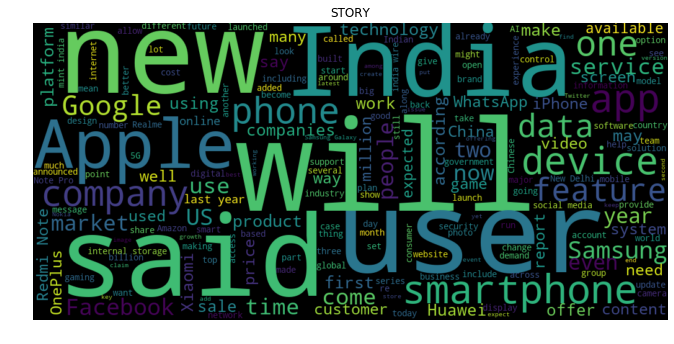

In [252]:
create_wordcloud(train, ["STORY"], "SECTION", 1)

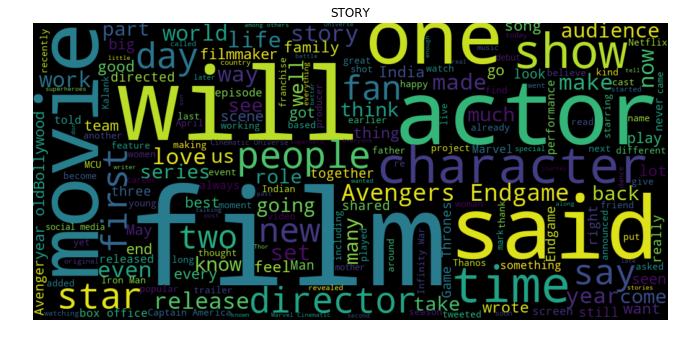

In [253]:
create_wordcloud(train, ["STORY"], "SECTION", 2)

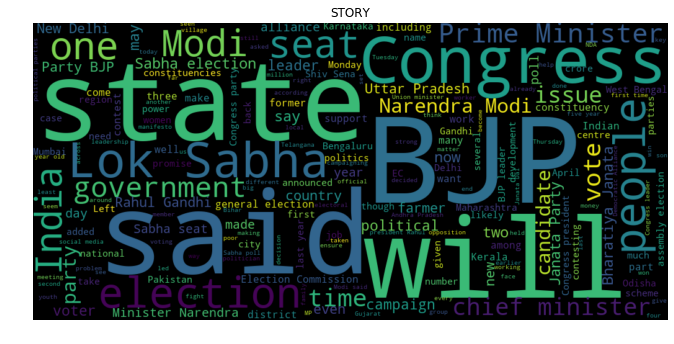

In [254]:
create_wordcloud(train, ["STORY"], "SECTION", 0)

In [255]:
repeated_reviews = train['STORY'].value_counts()

In [256]:
display(repeated_reviews.to_frame().head())

,STORY
This story has been published from a wire agency feed without modifications to the text. Only the headline has been changed.,28
"The consensus reads, “Exciting, entertaining, and emotionally impactful, Avengers: Endgame does whatever it takes to deliver a satisfying finale to Marvel’s epic Infinity Saga",3
"Social media in the world's largest democracy have become a hotbed for circulation of fake political news and tech firms face intense scrutiny ahead of a general election due before May, where Prime Minister Narendra Modi will seek a second term.\n\n\nIn a circular late on Thursday, the parliamentary committee on information technology, chaired by Anurag Thakur, a lawmaker from Modi's ruling Bharatiya Janata Party, said it would hear the views of officials from Facebook and its units on March 6.\n\n\nThe subject would be ""safeguarding citizens' rights on social or online news media platforms,"" it added.\n\n\nIt was not immediately clear whether the panel had asked Indian or global executives of the three firms to appear.",3
"We will leave no stone unturned to make the audience feel that they have got something fresh, new and exciting",3
"Facebook, WhatsApp and Twitter have overhauled policies to boost transparency ahead of the general election and rein in misinformation.\n\n\nAlphabet Inc's Google this week launched a programme to train journalists in areas such as online verification and fact checking before the polls.\n\n\nThis story has been published from a wire agency feed without modifications to the text. Only the headline has been changed.",3


In [257]:
train[train['STORY'] == repeated_reviews.index[0]]

,STORY,SECTION,story_length,story_word_count
196,This story has been published from a wire agen...,0,124,21
463,This story has been published from a wire agen...,3,124,21
835,This story has been published from a wire agen...,1,124,21
1929,This story has been published from a wire agen...,0,124,21
2365,This story has been published from a wire agen...,1,124,21
2702,This story has been published from a wire agen...,3,124,21
2786,This story has been published from a wire agen...,1,124,21
2969,This story has been published from a wire agen...,3,124,21
3422,This story has been published from a wire agen...,1,124,21
3800,This story has been published from a wire agen...,1,124,21


In [258]:
repeated_reviews.index[1]

'The consensus reads, “Exciting, entertaining, and emotionally impactful, Avengers: Endgame does whatever it takes to deliver a satisfying finale to Marvel’s epic Infinity Saga'

In [259]:
test[test['STORY'] == repeated_reviews.index[1]]

,STORY,story_length,story_word_count


So many duplicates text with different Section, So we can assume that it is a multi label classification problem.

In [260]:
multi_label_data = defaultdict(list)

for key, grp in train.groupby(['STORY']):
    #print(key)
    multi_label_data['STORY'].append(key)
    multi_label_data['SECTION'].append(list(grp.SECTION.values))

In [261]:
multi_label_df = pd.DataFrame(multi_label_data)
multi_label_df["info"] = multi_label_df['STORY']

In [262]:
multi_label_df.head()

,STORY,SECTION,info
0,"In January OPEC, Russia and other non-members...",[3],"In January OPEC, Russia and other non-members..."
1,"In the run up to the polls, Rahul Gandhi has ...",[0],"In the run up to the polls, Rahul Gandhi has ..."
2,The Indian government has formulated new IT g...,[1],The Indian government has formulated new IT g...
3,YouTube has not yet announced a definitive pl...,[1],YouTube has not yet announced a definitive pl...
4,"Zinc fell for a third session on Tuesday, hit...",[3],"Zinc fell for a third session on Tuesday, hit..."


In [263]:
mul_binarizer = MultiLabelBinarizer()
mul_binarizer.fit(multi_label_df.SECTION)
mul_binarizer.classes_

array([0, 1, 2, 3], dtype=object)

In [264]:
y_trans = mul_binarizer.transform(multi_label_df.SECTION)
y_trans

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [265]:
target_distribution(multi_label_df, 'SECTION', 30)

In [266]:
GLOVE_EMBEDDING_FILE = 'dist/glove.840B.300d.txt'

In [267]:
glove_embeddings = None
glove_embeddings_file = "preprocessed_glove.pkl"
try:
    with open(os.path.join("dist", glove_embeddings_file), "rb") as f:
        glove_embeddings = pickle.load(f)
        print(f'loaded {len(glove_embeddings)} word vectors ')
        print("Read preprocessed data from cache file:", glove_embeddings_file)
except:
    print("File not found")
    pass  # unable to read from cache, but that's okay

if glove_embeddings is None:
    glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
    print(f'loaded {len(glove_embeddings)} word vectors ')
    with open(os.path.join("dist", glove_embeddings_file), "wb") as f:
        pickle.dump(glove_embeddings, f)
        print("Wrote preprocessed data to cache file:", glove_embeddings_file)

loaded 2196008 word vectors 
Read preprocessed data from cache file: preprocessed_glove.pkl


In [268]:
vocab = build_vocab(list(multi_label_df['info'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 48.74% of vocab
Found embeddings for  88.55% of all text


[('However,', 419),
 ('year,', 369),
 ('OnePlus', 342),
 ('Redmi', 322),
 ('“The', 311),
 ('₹', 309),
 ('it’s', 305),
 ('India,', 253),
 ('said,', 250),
 ('don’t', 243)]

In [269]:
tokenizer = TreebankWordTokenizer()
def preprocessing(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    cleantext = cleantext.replace('.',' ')
    cleantext = cleantext.replace('₹',' ')
    x = tokenizer.tokenize(cleantext)
    x = ' '.join(x)
    return x.split()

In [270]:
preprocessing("I didn't know")

['I', 'did', "n't", 'know']

In [271]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocessing)))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 84.66% of vocab
Found embeddings for  98.64% of all text


[('OnePlus', 374),
 ('Redmi', 338),
 ('mint-india-wire', 126),
 ('FY19', 77),
 ('Zenfone', 67),
 ('Kalank', 66),
 ('NYAY', 62),
 ('Sumalatha', 46),
 ('Fadnavis', 40),
 ('4,000mAh', 39)]

In [272]:
white_list = string.ascii_letters + string.digits + ' '
white_list += "'"

In [273]:
white_list

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '"

In [274]:
review_chars = build_vocab(list(multi_label_df["info"]))
review_symbols = ''.join([c for c in review_chars if not c in white_list])
review_symbols

',-—+.\n/:"()“”&!@…#’_₹%$?–à■;[]|*‘>♥️🌸👏🏼🙏👍😊💪′😉Ó€¥ó\u2009аé❤\u2003✅😍💥🔥⭐`😁👊💋💃🏻\U0001f970\u200a😘\u2066\u2069✨🎭ö💛இராவணகோட்ம=£ñ💝😭~💕≈😇🚀😎☺🎉\ufeff🙈ë°×🌟✍🌺🎂हमआपकासयोगँतेैंरथदजीबभईनएख़ूअु😌´®💯'

In [275]:
glove_chars = ''.join([c for c in tqdm(glove_embeddings) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])

symbols_to_delete = ''.join([c for c in review_symbols if not c in glove_symbols])
symbols_to_delete

'\n₹️🌸👏🏼🙏👍😊💪😉\u2009\u2003😍💥🔥😁👊💋💃🏻\U0001f970\u200a😘\u2066\u2069🎭💛இரவணகோடம💝😭💕😇🚀😎🎉\ufeff🙈🌟🌺🎂हमआपकासयोगँतेैंरथदजीबभईनएख़ूअु😌💯'

In [276]:
def preprocess_5(x):
    x = ' '.join(preprocessing(x))
    x = x.replace('.',' ')
    x = x.replace(',','')
    x = x.replace(';','')
    x = x.replace('"','')
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    x = re.sub('[+/-]', ' ', x)
    x = re.sub('[()]', ' ', x)

    x = "".join([ x[i] for i in range(len(x)) if x[i] not in symbols_to_delete])
    return x

In [277]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocess_5).str.split()))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 87.27% of vocab
Found embeddings for  98.91% of all text


[('OnePlus', 374),
 ('Redmi', 338),
 ('FY19', 81),
 ('Zenfone', 67),
 ('Kalank', 66),
 ('NYAY', 62),
 ('48MP', 48),
 ('Sumalatha', 46),
 ('FY20', 41),
 ('Fadnavis', 41)]

In [278]:
unique_topics = mul_binarizer.classes_
train = multi_label_df
#test = test[~test[['STORY']].duplicated()]

In [279]:
X_train = train['info'].apply(preprocess_5)
X_test = test['STORY'].apply(preprocess_5)

In [280]:
from keras.preprocessing import text, sequence

n_unique_words = None
tokenizer = text.Tokenizer(num_words = n_unique_words)
tokenizer.fit_on_texts(list(X_train) + list(X_test))

In [281]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [282]:
X_train_len = [len(x) for x in X_train]
pd.Series(X_train_len).describe()

count    7548.000000
mean      113.114732
std        89.635523
min        10.000000
25%        55.000000
50%        93.000000
75%       145.000000
max      1050.000000
dtype: float64

In [283]:
X_test_len = [len(x) for x in X_test]
pd.Series(X_test_len).describe()

count    2748.000000
mean      110.416303
std        88.422686
min        14.000000
25%        54.000000
50%        88.000000
75%       140.000000
max      1159.000000
dtype: float64

In [284]:
MAX_LEN = 200
MAX_WORDS = len(tokenizer.word_index) + 1

X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [285]:
embedding_matrix = None
cache_file = "preprocessed_data.pkl"
try:
    with open(os.path.join("dist", cache_file), "rb") as f:
        embedding_matrix = pickle.load(f)
        print(embedding_matrix.shape)
        print("Read preprocessed data from cache file:", cache_file)
except:
    print("File not found")
    pass  # unable to read from cache, but that's okay

if embedding_matrix is None:
    embedding_matrix = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_FILE)
    print(embedding_matrix.shape)
    with open(os.path.join("dist", cache_file), "wb") as f:
        pickle.dump(embedding_matrix, f)
        print("Wrote preprocessed data to cache file:", cache_file)

(38756, 300)
Read preprocessed data from cache file: preprocessed_data.pkl


In [303]:
# Hyperparameters
batch_size = 32
num_epochs = 20
# Learning Rate
learning_rate = 0.01
# Output size
output_dim = 4
hidden_dim = 128
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [304]:
print(X_train.shape)
print(y_trans.shape)

train_x, val_x, train_y, val_y = train_test_split(X_train, y_trans, random_state=33)

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(torch.from_numpy(train_x).long(), torch.from_numpy(train_y).float().squeeze())
val_sample_ds = torch.utils.data.TensorDataset(torch.from_numpy(val_x).long(), torch.from_numpy(val_y).float().squeeze())
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=batch_size)
var_sample_dl = torch.utils.data.DataLoader(val_sample_ds, batch_size=batch_size)

(7548, 200)
(7548, 4)


In [305]:
class RNNClassifier(nn.Module):
    """
    This is the RNN model will be using to perform Text Classification.
    """

    def __init__(self, embedding_matrix, hidden_dim, vocab_size, output_dim, seq_len):
        """
        Initialize the model by settingg up the various layers.
        MAX_WORDS = vocab_size
        """
        super(RNNClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.seq_len = seq_len
        self.embedding_dim = embedding_matrix.shape[1] 
        self.embedding_matrix = embedding_matrix
        
        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.5)
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=hidden_dim, kernel_size=1, bias=False)        
        self.dense = nn.Linear(in_features=hidden_dim * 6, out_features=output_dim)
        self.drop_en = nn.Dropout(p=0.6)
        self.embedding_dropout = nn.Dropout2d(0.1)

        self.sig = nn.Sigmoid()
        
        self.word_dict = None
        self.init_weights()
    
    def init_weights(self):
        
        for name, param in self.gru.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
                    
        initrange = 0.08
        self.embedding.weight = nn.Parameter(torch.tensor(self.embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.dense.bias.data.fill_(0)
        self.dense.weight.data.normal_(0.0, (1.0 / np.sqrt(self.dense.in_features)))
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        
        batch_size = x.size(0)       
        #embeds = self.embedding(x)
        seq_len = np.full((batch_size,), 100)
        
        #print(seq_len.shape)
        
        #packed_input = pack_padded_sequence(embeds, seq_len, batch_first=True)
        
        #embeds = embeds.permute(1, 0, 2)
        #h_gru, hh_gru = self.gru(packed_input, None)
        
        #out_rnn, _ = pad_packed_sequence(h_gru, batch_first=True)
        
        #h_gru = h_gru.select(1, self.hidden_dim).contiguous()
        #h_gru = h_gru.view(-1, self.hidden_dim)
        #h_gru = h_gru.unsqueeze_(-1)
        
        #print(out_rnn.shape)
        
        #conv_x = self.conv(out_rnn)
        
        #avg_pool = torch.mean(conv_x, 1)
        #max_pool, _ = torch.max(conv_x, 1)
        
        #conc = torch.cat((avg_pool, max_pool), 1)
        #out = self.dense(conc)
        
        h_embedding = self.embedding(x)
        
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)), dim=0)
        #print(h_embedding.shape)
        #print("emb", h_embedding.size())
        #h_lstm, _ = self.lstm(h_embedding)
        #print("lst",h_lstm.size())
        h_gru, hh_gru = self.gru(h_embedding)
        hh_gru = hh_gru.view(-1, 2*self.hidden_dim )
        #print("gru", h_gru.size())
        #print("h_gru", hh_gru.size())

        # Layer 5: is defined dynamically as an operation on tensors.
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        #print("avg_pool", avg_pool.size())
        #print("max_pool", max_pool.size())

        # the extra features you want to give to the model
        #f = torch.tensor(x[1], dtype=torch.float).to(device)
        #print("f", f.size())

        # Layer 6: A concatenation of the last state, maximum pool, average pool and 
        # additional features
        conc = torch.cat(( hh_gru, avg_pool, max_pool), 1)
        #print("conc", conc.size())

        # passing conc through linear and relu ops
        
        conc = self.dense(conc)
        #conc = self.relu(self.linear(conc))
        conc = self.drop_en(conc)
        #out = self.out(conc)
        
        return self.sig(conc.squeeze())

In [306]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_fn, device):
    train_loss = 0
    val_loss = 0
    valid_corrects = 0
    valid_loss_min = np.Inf
    for epoch in range(1, epochs + 1):
        model.train()
        for batch in train_loader:
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            model.zero_grad()
            optimizer.zero_grad()
            
            #batch_len = batch_X.t()[0,:]            
            #print(seq_lengths)
            
            # TODO: Complete this train method to train the model provided.
            #with torch.no_grad():
            output = model(batch_X)
            #print('output')
            #_, batch_y = batch_y.max(dim=1)            
            #batch_y = torch.autograd.Variable(batch_y)
            #batch_y = batch_y.reshape(-1,1)
            #print(output)
            
            #print(output)
            #print(batch_y)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            #print(loss.item())
            #break
        model.eval()
        for batch in val_loader:
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # model.zero_grad()
            #optimizer.zero_grad()
            # TODO: Complete this train method to train the model provided.
            with torch.no_grad():
                output = model(batch_X)
                _, preds = torch.max(output, 1)
            
            #_, batch_y = batch_y.max(dim=1)            
            #batch_y = torch.autograd.Variable(batch_y)
            #batch_y = batch_y.reshape(-1,1)
            #print(output)
            
            _, preds_y = torch.max(batch_y, 1)
            loss = loss_fn(output, batch_y)            
            val_loss += loss.item()
            valid_corrects += torch.sum(preds == preds_y)
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        valid_corrects = valid_corrects.double() / len(val_loader.dataset)
        
        print("Epoch: {}, BCE Train Loss: {} Valid Loss {}".format(epoch, train_loss, val_loss))
        print("Validation Accuracy {} ".format(valid_corrects))
        if val_loss < valid_loss_min:
            with open('trained_rnn_new', 'wb') as pickle_file:
                torch.save(model.state_dict(), 'dist/save/trained_rnn_new')
                print("Model is saved")
            valid_loss_min = val_loss
        val_loss = 0
        train_loss = 0
        valid_corrects = 0
        #break
    return model

In [307]:
#model = DNNClassifier(hidden_dim, input_size, output_size).to(device)
model = RNNClassifier(embedding_matrix, hidden_dim, MAX_WORDS, output_dim, MAX_LEN).to(device)
print(model)
#summary(model, (50, 200), batch_size)
#model.load_state_dict(torch.load('dist/save/trained_rnn_new'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
loss_fn = torch.nn.BCELoss()
#loss_fn = nn.MultiLabelSoftMarginLoss()
#loss_fn = nn.BCEWithLogitsLoss()
train(model, train_sample_dl, var_sample_dl, num_epochs, optimizer, loss_fn, device)

RNNClassifier(
  (embedding): Embedding(39601, 300)
  (gru): GRU(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (conv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
  (dense): Linear(in_features=768, out_features=4, bias=True)
  (drop_en): Dropout(p=0.6)
  (embedding_dropout): Dropout2d(p=0.1)
  (sig): Sigmoid()
)
Epoch: 1, BCE Train Loss: 0.5854463277563537 Valid Loss 0.2615407306258961
Validation Accuracy 0.8913619501854796 
Model is saved
Epoch: 2, BCE Train Loss: 0.5013632621132048 Valid Loss 0.24333605751142665
Validation Accuracy 0.8961314255431903 
Model is saved
Epoch: 3, BCE Train Loss: 0.5098143767165599 Valid Loss 0.15875278084965075
Validation Accuracy 0.9104398516163222 
Model is saved
Epoch: 4, BCE Train Loss: 0.5196022125287244 Valid Loss 0.20317441098770853
Validation Accuracy 0.8781134075251722 
Epoch: 5, BCE Train Loss: 0.5331966594114141 Valid Loss 0.16533074944706286
Validation Accuracy 0.8982511923688394 


KeyboardInterrupt: 

In [308]:
model.load_state_dict(torch.load('dist/save/trained_rnn_new'))
model.eval()

RNNClassifier(
  (embedding): Embedding(39601, 300)
  (gru): GRU(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (conv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
  (dense): Linear(in_features=768, out_features=4, bias=True)
  (drop_en): Dropout(p=0.6)
  (embedding_dropout): Dropout2d(p=0.1)
  (sig): Sigmoid()
)

In [309]:
valid_corrects = 0

for batch in var_sample_dl:
    batch_X, batch_y = batch

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    
    _, preds_y = torch.max(batch_y, 1)

    # TODO: Complete this train method to train the model provided.
    with torch.no_grad():
        output = model(batch_X)
        _, preds = torch.max(output, 1)

    valid_corrects += torch.sum(preds == preds_y)
    
valid_corrects = valid_corrects.double() / len(var_sample_dl.dataset)
print("Validation Accuracy {} ".format(valid_corrects))

Validation Accuracy 0.9104398516163222 


In [310]:
print(X_test.shape)
predict_topics = list()
for i in range(X_test.shape[0]):
    preds = []
    #review = X_test[i]
    #review = review.to(device)
    #review = torch.from_numpy(X_test[i]).long()
    review = torch.LongTensor(X_test[i], device=device)
    #review = review.to(device)
    review = review.unsqueeze(0)
    #  view (input, hx, batch_sizes).
    #review = review.view(1, 1, -1)
    with torch.no_grad():
        output = model(review)
        preds = output.squeeze().cpu().flatten().numpy()
    
    #print(preds)
    #preds = int(output.squeeze().cpu().flatten().numpy())
    #print(preds)
    predict_topics.append(preds)

print(predict_topics)

(2748, 200)


RuntimeError: index out of range at ..\aten\src\TH/generic/THTensorEvenMoreMath.cpp:193

<h1>How to handle top N ?</h1>
<p>If that review occurs once in the test data, submit the most correlated prediction. If the occurrence is 2, submit the top 2 topics. And so on.</p>

In [ ]:
output = test_csv['STORY'].copy()
output['SECTION'] = np.nan
print(test.shape[0])

In [ ]:
for i in range(test.shape[0]):
    story = test.iloc[i]['STORY']
    output_filter = output[(output['STORY'] == story)]
    test_pred = predict_topics[i]
    test_topic = np.argsort(test_pred)[::-1]
    p_topics = [ unique_topics[_] for _ in test_topic][:output_filter.shape[0]]
    
    output.loc[output_filter.index, 'SECTION'] = p_topics

In [ ]:
#print(np.asarray(pred).reshape(-1, 1))
submission = pd.DataFrame(0, index=np.arange(len(pred)), columns=["SECTION"])
submission["SECTION"] = output['SECTION']
print(submission.shape)

In [ ]:
submission.to_csv("dist/submission_out.csv", index=False)
submission.head()

In [ ]:
%reset